# Test trained neural density estimator (NPE)

In [6]:
# Imports
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from models import WF, WF_bottleneck, WF_DFE, WF_FD
import pickle

In [7]:
from sbi.inference import RejectionPosterior
from inference_utils import get_prior
# Load the posterior and test data
with open('posterior.pkl', 'rb') as f:
    posterior = pickle.load(f)

# convert to importance sampling posterior
# posterior = RejectionPosterior(potential_fn=posterior.potential_fn,proposal=get_prior())

X = pd.read_csv('test_sims/WF_sims.csv')
theta = pd.read_csv('test_sims/WF_thetas.csv')

# Realistic test
theta = theta[X.iloc[:,-1] > 0.2]
X = X[X.iloc[:,-1] > 0.2]



In [8]:
%%capture
# Test function - accuracy
# Compare sample mean to true parameter
def test_estimator(posterior, X, theta,output_file_name='test_results.csv'):
    output_data = pd.DataFrame(columns = ['s','mu'], index = [i for i in range(len(theta))])
    for i in range(len(X)):
        xi = X.iloc[i,:]
        true_param = theta.iloc[i,:]
        samps = posterior.set_default_x(xi).sample((100,))
        m = np.array(samps.mean(0))
        output_data.iloc[i,:] = m-true_param
    output_data.to_csv(output_file_name)
    return output_data

test_results = test_estimator(posterior, X, theta)

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\nadav\AppData\Local\Temp\ipykernel_5096\3716009228.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('$\mu$')


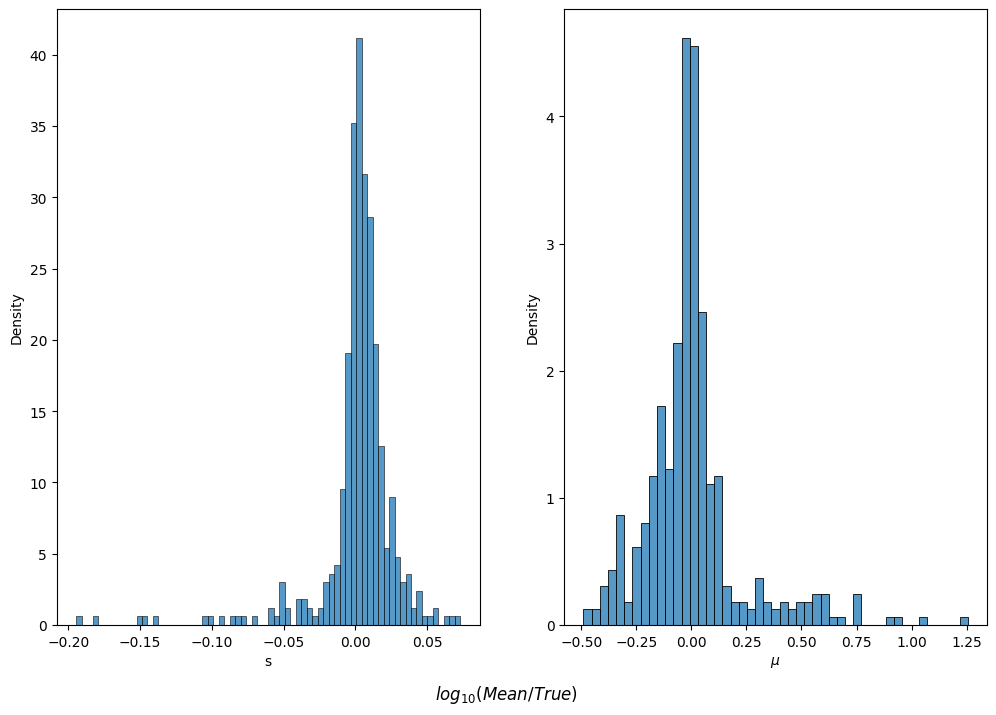

In [9]:
def plot_test_results(test_results):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(test_results['s'], ax = ax[0], stat='density')
    sns.histplot(test_results['mu'], ax = ax[1], stat='density')
    fig.supxlabel('$log_{10}({Mean}/{True})$')
    ax[0].set_xlabel('s')
    ax[1].set_xlabel('$\mu$')
plot_test_results(test_results)

In [ ]:
%%capture
# Fast coverage function
import torch
def coverage(posterior, X, theta):
    covs = []
    for i in range(len(X)):
        samples = posterior.set_default_x(X.iloc[i,:]).sample((200,))
        params = torch.tensor(theta.iloc[i,:], dtype=torch.float32)
        covs.append((posterior.log_prob(samples) > posterior.log_prob(params)).sum()/200)
    return np.array(covs)

covs = coverage(posterior, X, theta)

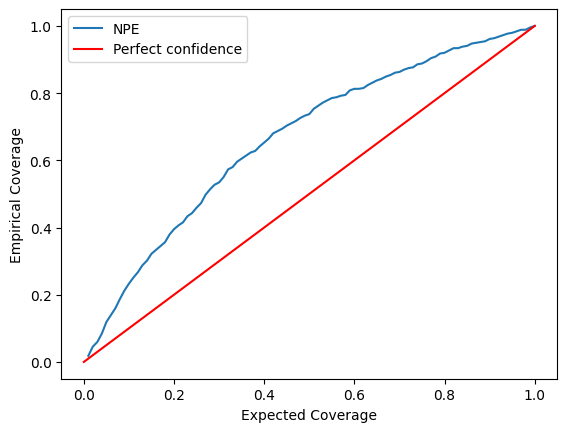

In [ ]:
def plot_coverage(covs):
    H,X1 = np.histogram(covs, bins = 100, range = (0,1), density = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    plt.plot(X1[1:], F1, label = 'NPE')
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='red', label='Perfect confidence')
    plt.xlabel('Expected Coverage')
    plt.ylabel('Empirical Coverage')
    plt.legend()
plot_coverage(covs)

In [ ]:
%%capture
# Test on simulations from another model - DFE

X_DFE = pd.read_csv('test_sims/WF_DFE_sims.csv').iloc[:400,:]
theta_DFE = pd.read_csv('test_sims/WF_DFE_thetas.csv').iloc[:400,:]
theta = pd.read_csv('test_sims/WF_DFE_thetas.csv').iloc[:400,:]
# Realistic test
theta_DFE = theta[X_DFE.iloc[:,-1] > 0.2]
X_DFE = X_DFE[X.iloc[:,-1] > 0.2]

test_results_DFE = test_estimator(posterior, X_DFE, theta_DFE, output_file_name='test_results_DFE.csv')

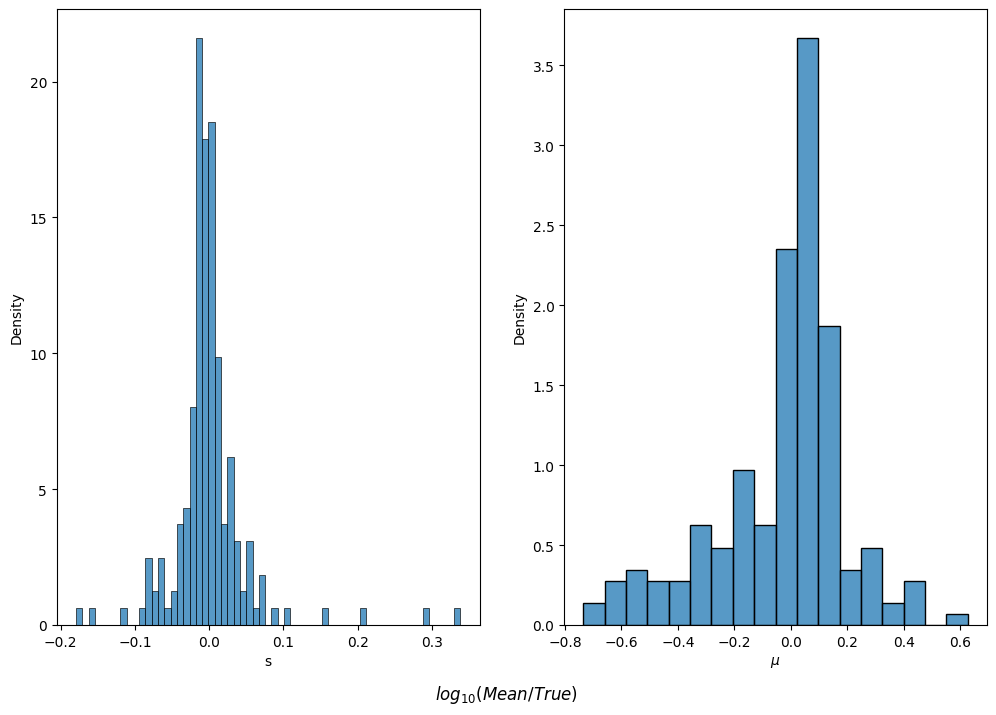

In [ ]:
plot_test_results(test_results_DFE)

In [ ]:
%%capture
covs_DFE = coverage(posterior, X_DFE, theta_DFE)

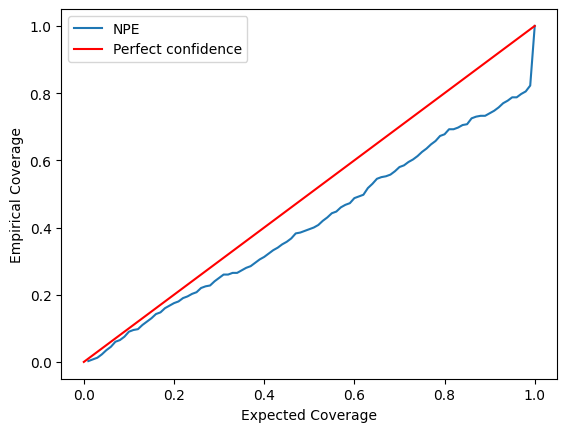

In [ ]:
plot_coverage(covs_DFE)

In [ ]:
%%capture
# Test on simulations from another model - bottleneck

X_bottleneck = pd.read_csv('test_sims/WF_bottleneck_sims.csv')
theta_bottleneck = pd.read_csv('test_sims/WF_bottleneck_thetas.csv')
# Realistic test
theta_bottleneck = theta_bottleneck[X_bottleneck.iloc[:,-1] > 0.2]
X_bottleneck = X_bottleneck[X_bottleneck.iloc[:,-1] > 0.2]

test_results_bottleneck = test_estimator(posterior, X_bottleneck, theta_bottleneck, output_file_name='test_results_bottleneck.csv')

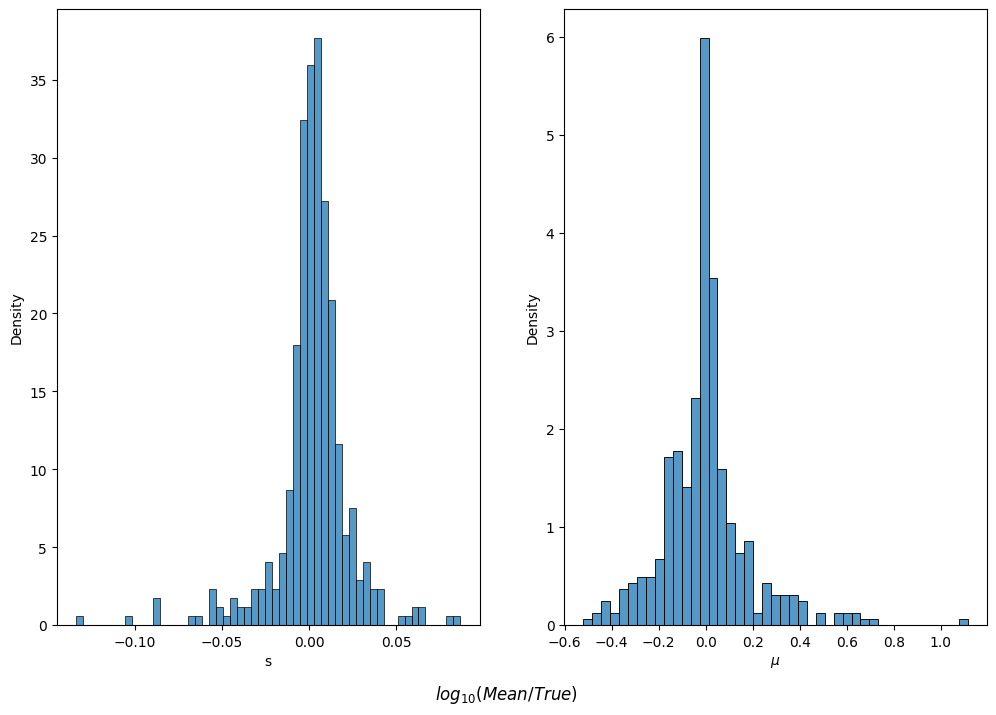

In [ ]:
plot_test_results(test_results)

In [ ]:
%%capture
X_bottleneck = pd.read_csv('test_sims/WF_bottleneck_sims.csv')
theta_bottleneck = pd.read_csv('test_sims/WF_bottleneck_thetas.csv')
covs_bottleneck = coverage(posterior, X_bottleneck, theta_bottleneck)

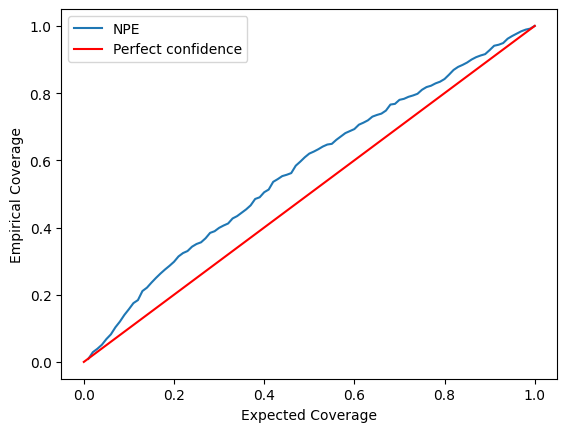

In [ ]:
plot_coverage(covs_bottleneck)